# Covid Sales Prediction

### 목차

In [1]:
"""
1. 모듈 임포트

2. 데이터 처리

3. 그래프 확인

4. 데이터 정규화 

5. 데이터 연관성 분석

6. 이상치 처리
    -이상치 확인 함수 생성
    -분위별 이상치 1차 검색
    -이상치 치환
    -처리 후 잔여 개수 확인

7. 데이터셋 편집

8. 딥러닝 모델

9. 결과 표시
    -그래프 표시
    -그래프 비교 결과
    -성능 측정 지표

10. 예측값과 실제값 결과 csv 파일 저장
"""

'\n1. 모듈 임포트\n\n2. 데이터 처리\n\n3. 그래프 확인\n\n4. 데이터 정규화 \n\n5. 데이터 연관성 분석\n\n6. 이상치 처리\n    -이상치 확인 함수 생성\n    -분위별 이상치 1차 검색\n    -이상치 치환\n    -처리 후 잔여 개수 확인\n\n7. 데이터셋 편집\n\n8. 딥러닝 모델\n\n9. 결과 표시\n    -그래프 표시\n    -그래프 비교 결과\n    -성능 측정 지표\n\n10. 예측값과 실제값 결과 csv 파일 저장\n'

### <화면 가로 확장>

In [2]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import h5py

### <GPU 확인>

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 2. 데이터

#### 배달의 민족 월별 정산 데이터 저장

In [4]:
try:
    os.mkdir('./Data')
    os.mkdir('./Data/BaeMin')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


In [5]:
for BM in range(1, len(os.listdir('./Original_Data/BaeMin'))+1):
    if BM<7:
        count_num='0'+str(BM)
        data_bm = pd.read_excel('./Original_Data/BaeMin/배달의민족-2021년'+count_num+'월_정산명세서_성정환사장님.xlsx', sheet_name='상세')
        data_bm = data_bm.iloc[3:, [0, 20]] # 행, 열 제한으로 필요 정보 추출
    if (BM>=7 and BM<10):
        count_num='0'+str(BM)
        data_bm = pd.read_excel('./Original_Data/BaeMin/배달의민족-2021년'+count_num+'월_정산명세서_성정환사장님.xlsx', sheet_name='상세')
        data_bm = data_bm.iloc[3:, [0, 21]] # 행, 열 제한으로 필요 정보 추출
    if BM>=10:
        count_num=str(BM)
        data_bm = pd.read_excel('./Original_Data/BaeMin/배달의민족-2021년'+count_num+'월_정산명세서_성정환사장님.xlsx', sheet_name='상세')
        data_bm = data_bm.iloc[3:, [0, 21]] 
    
    data_bm = data_bm.reset_index(drop=True) # 인덱스 초기화
    data_bm.to_csv('./Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv', header=False, encoding='cp949')
    data_bm_named=pd.read_csv('./Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv', names=['Date','Won'], encoding='cp949')
    data_bm_named.to_csv('./Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv', encoding='cp949')

C:\Users\82108\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [6]:
# 1년 단위 파일로 병합
bm_y = pd.DataFrame()
for y in range(1, len(os.listdir('./Data/BaeMin'))+1):
    if y<=9:
        count_num='0'+str(y)
    else:
        count_num=str(y)
        
    file = './Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv'
    bm_m= pd.read_csv(file, encoding='cp949')
    bm_y = pd.concat([bm_y, bm_m])
    
bm_y = bm_y.drop([bm_y.columns[0]], axis=1)
bm_y = bm_y.reset_index(drop=True)
bm_y.to_csv('./Data/배달의 민족_2021년_수익정산.csv', encoding='cp949')

# 중간에 0이 있는데 코로나 때문에 0이 된게 아니라면 이상치 처리를 해야함.

In [7]:
data_bm_sum=pd.DataFrame(columns=['Date','Won'])
data_bm=pd.read_csv('./Data/배달의 민족_2021년_수익정산.csv', encoding='cp949')
data_bm = data_bm.drop([data_bm.columns[0]], axis=1)

for D in range(len(data_bm)-1):
    y=data_bm['Date'][D][0:4]
    m=data_bm['Date'][D][5:7]
    d=data_bm['Date'][D][8:10]
    YMD=y+m+d
    if(data_bm['Date'][D]==data_bm['Date'][D+1]):
        won=int(data_bm['Won'][D]+data_bm['Won'][D+1])
        new_data=[YMD, won]
        data_bm_sum.loc[D]=new_data
    else:
        new_data=[YMD, int(data_bm['Won'][D])]
        data_bm_sum.loc[D]=new_data

for D in range(len(data_bm_sum)):
    try:
        if(data_bm_sum['Date'][D]==data_bm_sum['Date'][D+1]):
            data_bm_sum=data_bm_sum.drop(D+1, axis=0)

    except KeyError:
        pass
    
print(data_bm_sum)
data_bm_sum = data_bm_sum.reset_index(drop=True)
data_bm_sum.to_csv('./Data/배달의 민족_2021년_수익정산_동일날짜합.csv', encoding='cp949')

         Date      Won
0    20210104   249789
2    20210105   211252
3    20210106   152762
5    20210107  1310714
7    20210108   252126
..        ...      ...
418  20211123    48750
420  20211124   123086
422  20211125   572818
424  20211125     4835
425  20211126    98345

[260 rows x 2 columns]


#### 서울시 기상 정보 저장

In [12]:
data_weather = pd.read_excel('./Original_Data/OBS_ASOS_DD_20211123223955.xlsx')
data_weather = data_weather.iloc[:, [2,3,5,6]]
data_weather.insert(2, '강수여부', 1) # 컬럼 새로 생성 후 우선은 다 비오는 경우인 '1'로 입력

for num in range(len(data_weather)):
    rain_values = data_weather.iloc[num, [3]].values[0] # 강수량 컬럼의 정보를 읽어옴
    if (str(rain_values)=='nan' or float(rain_values)==0.0):
        data_weather['강수여부'][num]=0 # 맑은 날은 0으로 값 변경
        data_weather['일강수량(mm)'][num]=0
        
data_weather = data_weather.reset_index(drop=True) # 인덱스 초기화
data_weather.to_csv('./Data/2021_서울_기상정보.csv', encoding='cp949')

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12860/2957362069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather['강수여부'][num]=0 # 맑은 날은 0으로 값 변경
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12860/2957362069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather['일강수량(mm)'][num]=0


#### 전국 Covid 정보 저장

In [10]:
data_covid = pd.read_excel('./Original_Data/코로나 현황.xlsx')
start_date=int(data_covid.loc[data_covid['날짜'] == 20210101].index[0])
data_covid = data_covid.iloc[start_date:, [0,1,4]]
data_covid = data_covid.reset_index(drop=True) # 인덱스 초기화
data_covid.to_csv('./Data/2021_KOREA_Covid.csv', encoding='cp949')

#### 거리두기 규제 및 집합 인원수 컬럼 추가

In [43]:
data_covid=pd.read_csv('./Data/2021_KOREA_Covid.csv', encoding='cp949')

data_covid['18시 전 규제 인원수']=np.NaN
data_covid['18시 후 규제 인원수']=np.NaN
data_covid['영업 제한 시각']=np.NaN

covid_rules={20210101: [5,5,21], 20210121: [5,5,21], 20210215: [5,5,22], 20210701: [9,9,24], 20210712: [5,3,24], 20211018: [9,9,24], 20211101: [10,10,27]}
# 시간 제한이 사라진 이후는 24시 이후 영업의 의미를 담기 위해 27로 설정.

for D in range (len(data_covid)):
    date=int(data_covid['날짜'][D])
    
    try:
        rules=covid_rules[date]
    except KeyError:
        rules=rules
    
    data_covid['18시 전 규제 인원수'][D]=rules[0]
    data_covid['18시 후 규제 인원수'][D]=rules[1]
    data_covid['영업 제한 시각'][D]=rules[2]
    
data_covid=data_covid.astype(int)
data_covid = data_covid.drop([data_covid.columns[0]], axis=1)
print(data_covid)
data_covid.to_csv('./Data/2021_KOREA_Covid+.csv', encoding='cp949')

           날짜  확진자수(양성)       검사수  18시 전 규제 인원수  18시 후 규제 인원수  영업 제한 시각
0    20210101     61753   4269308             5             5        21
1    20210102     62573   4302790             5             5        21
2    20210103     63230   4340830             5             5        21
3    20210104     64250   4376600             5             5        21
4    20210105     64964   4439352             5             5        21
..        ...       ...       ...           ...           ...       ...
322  20211119    409099  15848464            10            10        27
323  20211120    412305  15851670            10            10        27
324  20211121    415425  15854790            10            10        27
325  20211122    418252  15857617            10            10        27
326  20211123    420950  15860315            10            10        27

[327 rows x 6 columns]


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16764/1539669511.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_covid['18시 전 규제 인원수'][D]=rules[0]
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16764/1539669511.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_covid['18시 후 규제 인원수'][D]=rules[1]
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16764/1539669511.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_covid

In [13]:
Data_bm=pd.read_csv('./Data/배달의 민족_2021년_수익정산_동일날짜합.csv', encoding='cp949')
Data_weather=pd.read_csv('./Data/2021_서울_기상정보.csv', encoding='cp949')
Data_covid=pd.read_csv('./Data/2021_KOREA_Covid+.csv', encoding='cp949')

Data_weather2=Data_weather.iloc[:,[2,3,4,5]]
Data_bm2=Data_bm.iloc[:, [1,2]]

In [34]:
Data_C_W = pd.concat([Data_covid, Data_weather2],axis=1)
Data_C_W=Data_C_W[:-1] # 날씨 데이터는 11/23 데이터가 없기 때문에 맨 마지막 row 삭제

In [68]:
Data_C_W['Won']=0

C1=0
C2=0
      
while(True):
    try:
        if(int(Data_C_W['날짜'][C1])==int(Data_bm2['Date'][C2])):
            Data_C_W['Won'][C1]=Data_bm2['Won'][C2]
            C1+=1
            C2+=1

        if(int(Data_C_W['날짜'][C1])>int(Data_bm2['Date'][C2])):
            C2+=1

        if(int(Data_C_W['날짜'][C1])<int(Data_bm2['Date'][C2])):
            C1+=1
            
    except:
        break
        
Data_C_W_B=Data_C_W
Data_C_W_B = Data_C_W_B.drop([Data_C_W_B.columns[0]], axis=1)
Data_C_W_B.to_csv('./Data/2021_Data_Combined.csv', encoding='cp949')

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12860/754528038.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_C_W['Won'][C1]=Data_bm2['Won'][C2]


#### 최종 데이터 Import

In [174]:
Data_Combined=pd.read_csv('./Data/2021_Data_Combined.csv', encoding='cp949')
Data_Combined

,Unnamed: 0,날짜,확진자수(양성),검사수,18시 전 규제 인원수,18시 후 규제 인원수,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),평균 풍속(m/s),Won
0,0,20210101,61753,4269308,5,5,21,-4.2,0.0,0.0,2.0,0
1,1,20210102,62573,4302790,5,5,21,-5.0,0.0,0.0,2.6,0
2,2,20210103,63230,4340830,5,5,21,-5.6,0.0,0.0,2.0,0
3,3,20210104,64250,4376600,5,5,21,-3.5,0.0,0.0,1.7,249789
4,4,20210105,64964,4439352,5,5,21,-5.5,0.0,0.0,2.9,211252
...,...,...,...,...,...,...,...,...,...,...,...,...
321,321,20211118,406065,15845430,10,10,27,11.9,0.0,0.0,2.4,322402
322,322,20211119,409099,15848464,10,10,27,12.9,0.0,0.0,1.9,55371
323,323,20211120,412305,15851670,10,10,27,10.4,0.0,0.0,1.6,0
324,324,20211121,415425,15854790,10,10,27,10.4,1.0,5.9,1.9,0


### 4. 데이터 정규화

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [175]:
from sklearn.preprocessing import MinMaxScaler

# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_Combined.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['확진자수(양성)', '검사수', '18시 전 규제 인원수', '18시 후 규제 인원수', '영업 제한 시각', '평균기온(°C)', '강수여부', '일강수량(mm)', '평균 풍속(m/s)', 'Won']
Data_scaled = scaler.fit_transform(Data_Combined[scale_cols])
Data_scaled = pd.DataFrame(Data_scaled)
Data_scaled.columns = scale_cols

Data_scaled.insert(0, '날짜', Data_Combined['날짜'])
Data_scaled

,날짜,확진자수(양성),검사수,18시 전 규제 인원수,18시 후 규제 인원수,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),평균 풍속(m/s),Won
0,20210101,0.000000,0.000000,0.0,0.285714,0.0,0.229614,0.0,0.000000,0.189189,0.000000
1,20210102,0.002300,0.002889,0.0,0.285714,0.0,0.212446,0.0,0.000000,0.351351,0.000000
2,20210103,0.004143,0.006172,0.0,0.285714,0.0,0.199571,0.0,0.000000,0.189189,0.000000
3,20210104,0.007004,0.009259,0.0,0.285714,0.0,0.244635,0.0,0.000000,0.108108,0.190575
4,20210105,0.009007,0.014674,0.0,0.285714,0.0,0.201717,0.0,0.000000,0.432432,0.161173
...,...,...,...,...,...,...,...,...,...,...,...
321,20211118,0.965815,0.998948,1.0,1.000000,1.0,0.575107,0.0,0.000000,0.297297,0.245974
322,20211119,0.974325,0.999210,1.0,1.000000,1.0,0.596567,0.0,0.000000,0.162162,0.042245
323,20211120,0.983318,0.999487,1.0,1.000000,1.0,0.542918,0.0,0.000000,0.081081,0.000000
324,20211121,0.992070,0.999756,1.0,1.000000,1.0,0.542918,1.0,0.076227,0.162162,0.000000


### 5. 데이터 연관성 분석

In [176]:
Data_scaled.columns

Index(['날짜', '확진자수(양성)', '검사수', '18시 전 규제 인원수', '18시 후 규제 인원수', '영업 제한 시각',
       '평균기온(°C)', '강수여부', '일강수량(mm)', '평균 풍속(m/s)', 'Won'],
      dtype='object')

In [177]:
import scipy.stats as stats

# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)
def P_value(dataset, c1, c2):
    Correlation=stats.pearsonr(dataset[c1], dataset[c2])
    print('< '+c1+'-'+c2+' >')
    print('P-value ==>> %.3f\n' %Correlation[1])

for p in range(1, len(Data_scaled.columns)-1):
    P_value(Data_scaled, Data_scaled.columns[p], 'Won')

< 확진자수(양성)-Won >
P-value ==>> 0.093

< 검사수-Won >
P-value ==>> 0.029

< 18시 전 규제 인원수-Won >
P-value ==>> 0.284

< 18시 후 규제 인원수-Won >
P-value ==>> 0.678

< 영업 제한 시각-Won >
P-value ==>> 0.073

< 평균기온(°C)-Won >
P-value ==>> 0.006

< 강수여부-Won >
P-value ==>> 0.061

< 일강수량(mm)-Won >
P-value ==>> 0.027

< 평균 풍속(m/s)-Won >
P-value ==>> 0.783



In [178]:
Data_P = Data_scaled.drop(
    [Data_scaled.columns[1], Data_scaled.columns[3], Data_scaled.columns[4], Data_scaled.columns[5], Data_scaled.columns[7], Data_scaled.columns[9]], axis=1)

In [179]:
Data_P

,날짜,검사수,평균기온(°C),일강수량(mm),Won
0,20210101,0.000000,0.229614,0.000000,0.000000
1,20210102,0.002889,0.212446,0.000000,0.000000
2,20210103,0.006172,0.199571,0.000000,0.000000
3,20210104,0.009259,0.244635,0.000000,0.190575
4,20210105,0.014674,0.201717,0.000000,0.161173
...,...,...,...,...,...
321,20211118,0.998948,0.575107,0.000000,0.245974
322,20211119,0.999210,0.596567,0.000000,0.042245
323,20211120,0.999487,0.542918,0.000000,0.000000
324,20211121,0.999756,0.542918,0.076227,0.000000


### 이상치 처리

In [180]:
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_40 = np.percentile(df[column].values, 40)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    midlow_val = quantile_40-IQR_weight
    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_midlow = df[column][df[column] < midlow_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    
    return outlier_index_low, outlier_index_high, quantile_25, quantile_50, quantile_75, outlier_index_midlow, quantile_40

In [181]:
print('Low Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[0]))
print('High Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[1]))
print('MidLow Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[5]))

print('25% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[2]))
print('40% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[6]))
print('50% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[3]))
print('75% Value ==>> {}'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[4]))

Low Outlier ==>> Int64Index([], dtype='int64')

High Outlier ==>> Int64Index([  6,  11,  13,  34,  40,  48,  55,  63,  69,  76,  83,  90,  97,
            104, 111, 118, 132, 140, 195, 209, 216, 223, 237, 244, 251, 258,
            269, 272, 280, 287, 293, 300, 307],
           dtype='int64')

MidLow Outlier ==>> Int64Index([], dtype='int64')

25% Value ==>> 0.0

40% Value ==>> 0.031305837886831146

50% Value ==>> 0.060951893395508105

75% Value ==>> 0.11486601958932308


In [190]:
for sw in range(len(Data_P['Won'])):
    if (Data_P['Won'][sw]==0.000000):
        Data_P['Won'][sw]=get_outlier(df=Data_P, column='Won', weight=1.5)[6]
    else:
        pass

C:\Users\82108\AppData\Local\Temp/ipykernel_18992/2761080343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_P['Won'][sw]=get_outlier(df=Data_P, column='Won', weight=1.5)[6]


In [191]:
Data_P

,날짜,검사수,평균기온(°C),일강수량(mm),Won
0,20210101,0.000000,0.229614,0.000000,0.031306
1,20210102,0.002889,0.212446,0.000000,0.031306
2,20210103,0.006172,0.199571,0.000000,0.031306
3,20210104,0.009259,0.244635,0.000000,0.190575
4,20210105,0.014674,0.201717,0.000000,0.161173
...,...,...,...,...,...
321,20211118,0.998948,0.575107,0.000000,0.245974
322,20211119,0.999210,0.596567,0.000000,0.042245
323,20211120,0.999487,0.542918,0.000000,0.031306
324,20211121,0.999756,0.542918,0.076227,0.031306


In [149]:
"""
print('Quantity of Low Outlier ==>> {}\n'.format(len(get_outlier(df=Data_P, column='Won', weight=1.5)[0])))
print('Quantity of High Outlier ==>> {}\n'.format(len(get_outlier(df=Data_P, column='Won', weight=1.5)[1])))
"""

Quantity of Low Outlier ==>> 0

Quantity of High Outlier ==>> 33



### 7. 데이터셋 편집

In [192]:
TEST_SIZE = 20  # 10일치를 테스트셋으로 사용
WINDOW_SIZE = 1 # 얼마 동안의 과거 기반의 데이터에 기반하여 다음날의 값을 예측할 것인지 설정. 

train = Data_P[:-TEST_SIZE]
test= Data_P[-TEST_SIZE:]

In [193]:
test = test.reset_index(drop=True) # 인덱스 초기화

In [194]:
from sklearn.model_selection import train_test_split

feature_cols = ['검사수', '평균기온(°C)', '일강수량(mm)', 'Won']
label_cols = ['Won']

train_feature = train[feature_cols]
train_label = train[label_cols]

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, random_state=0, shuffle=False)

In [195]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [196]:
WINDOW_SIZE=1
BATCH_SIZE=128

In [197]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False) # 학습도 셔플 안해야 맞는게 아닌가??
valid_data = windowed_dataset(y_valid, WINDOW_SIZE, BATCH_SIZE, False)

In [198]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (128, 1, 1, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (128, 1, 1)


### 8. 딥러닝 모델

#### 1안

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.utils import plot_model
import keras
    
model = Sequential([
    Conv1D(filters=32, kernel_size=1, padding="causal",activation="relu", input_shape=[WINDOW_SIZE, 1]),
    TimeDistributed(Dense(64)),
    #LSTM(256, activation='relu',return_sequences=True),
    #Bidirectional(LSTM(128, activation='ReLU', return_sequences=True), merge_mode='concat'),
    #LSTM(128, activation='relu',return_sequences=True),
    #Bidirectional(LSTM(64, activation='ReLU', return_sequences=True), merge_mode='concat'),
    #LSTM(128, activation='ReLU', return_sequences = True),
    Bidirectional(LSTM(32, activation='ReLU', return_sequences=True), merge_mode='concat'),
    LSTM(32, activation='ReLU', return_sequences = False),
    Dense(1, activation='sigmoid')
                    ])

model.summary()
model.compile(loss='mean_squared_error', optimizer='Nadam')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 32)             64        
                                                                 
 time_distributed (TimeDistr  (None, 1, 64)            2112      
 ibuted)                                                         
                                                                 
 bidirectional_5 (Bidirectio  (None, 1, 64)            24832     
 nal)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 39,457
Trainable params: 39,457
Non-trai

#### 2안

In [199]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.utils import plot_model
import keras
    
model = Sequential([
    Conv1D(filters=64, kernel_size=1, padding="causal", input_shape=[WINDOW_SIZE, 1]),
    #TimeDistributed(Dense(32)),
    #LSTM(256, activation='relu',return_sequences=True),
    #Bidirectional(LSTM(128, activation='ReLU', return_sequences=True), merge_mode='concat'),
    LSTM(64, return_sequences=True),
    #Bidirectional(LSTM(32, activation='ReLU', return_sequences=True), merge_mode='concat'),
    LSTM(32, return_sequences = True),
    Bidirectional(LSTM(16, return_sequences=True), merge_mode='concat'),
    LSTM(16, return_sequences = False),
    Dense(1)
                    ])

model.summary()
model.compile(loss='mean_squared_error', optimizer='Adam')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 64)             128       
                                                                 
 lstm_26 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_27 (LSTM)              (None, 1, 32)             12416     
                                                                 
 bidirectional_9 (Bidirectio  (None, 1, 32)            6272      
 nal)                                                            
                                                                 
 lstm_29 (LSTM)              (None, 16)                3136      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                      

#### Plot model 저장

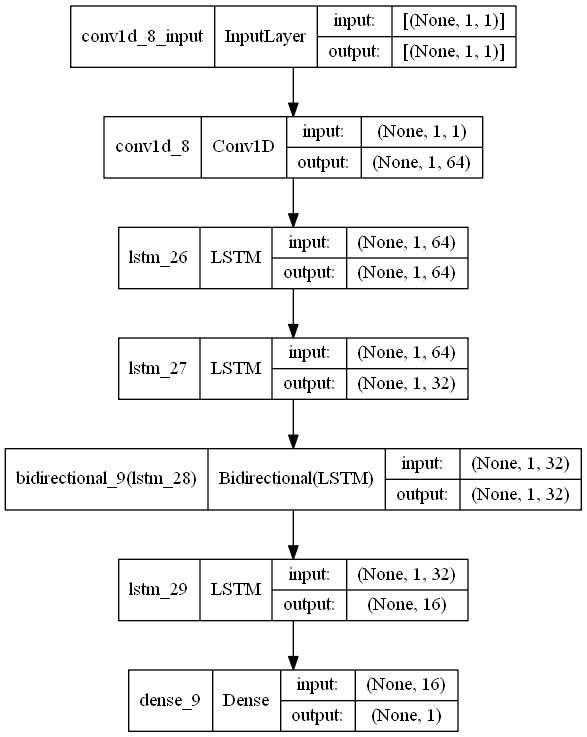

In [200]:
from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [202]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint_Covid.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=100, batch_size=32,validation_data=(valid_data), callbacks=[early_stop, checkpoint])

Epoch 1/100
      1/Unknown - 4s 4s/step - loss: 0.0388
Epoch 00001: val_loss improved from inf to 0.02375, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 6s 1s/step - loss: 0.0279 - val_loss: 0.0237
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0375
Epoch 00002: val_loss improved from 0.02375 to 0.02283, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 0s 82ms/step - loss: 0.0269 - val_loss: 0.0228
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0363
Epoch 00003: val_loss improved from 0.02283 to 0.02193, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 0s 83ms/step - loss: 0.0259 - val_loss: 0.0219
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 0.0351
Epoch 00004: val_loss improved from 0.02193 to 0.02107, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 0s 79ms/step - loss: 0.

In [203]:
model.load_weights(filename)
pred = model.predict(test['Won'])

pred.shape

(20, 1)

### 9. 결과 표시

In [204]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


In [205]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


<function matplotlib.pyplot.show(close=None, block=None)>

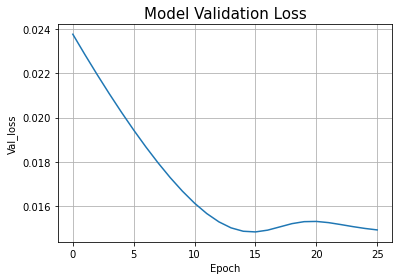

In [206]:
plt.title('Model Validation Loss', size='15')
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.savefig('./Result/CNN+LSTM/Graph/Model_Valdation_Loss.png')
plt.show

#### 성능 측정 지표

In [207]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

print('r2 >> %.4f' %r2(test['Won'], pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE(test['Won'], pred)) # 0에 가까워야 좋음
print('MSE >> %.4f' %MSE(test['Won'], pred)) # 0에 가까워야 좋음
print('RMSE >> %.4f' %np.sqrt(MSE(test['Won'], pred))) # 0에 가까워야 좋음
#print('RMSLE >> %.4f' %np.sqrt(MSLE(test['Won'], pred))) # 0에 가까워야 좋음

r2 >> 0.0260
MAE >> 0.0733
MSE >> 0.0089
RMSE >> 0.0942


In [208]:
RMSE = np.sqrt(MSE(test['Won'], pred))
RMSE_pct = round(1-RMSE, 5)*100
print('RMSE 측정 정확도 ==>> %.3f %%' %RMSE_pct)

RMSE 측정 정확도 ==>> 90.579 %


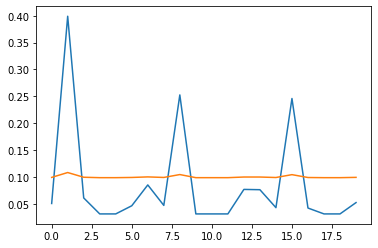

In [209]:
plt.plot(test['Won'])
plt.plot(pred)
plt.show()